In [20]:
import numpy as np
import pandas as pd

In [21]:

RI_TABLE = {1:0.00, 2:0.00, 3:0.58, 4:0.90, 5:1.12, 6:1.24, 7:1.32, 8:1.41, 9:1.45, 10:1.49}

def ahp_weights(A: np.ndarray):
    """A: pairwise matrix (nxn), returns (weights, CR, lambda_max)"""
    eigvals, eigvecs = np.linalg.eig(A)
    idx = np.argmax(eigvals.real)
    lam_max = eigvals.real[idx]
    w = eigvecs[:, idx].real
    w = w / w.sum()
    n = A.shape[0]
    CI = (lam_max - n) / (n - 1) if n > 2 else 0.0
    RI = RI_TABLE.get(n, 1.49)
    CR = CI / RI if RI > 0 else 0.0
    return w, CR, lam_max

def ratio_to_pairwise(values, clip_min=1/9, clip_max=9.0):
    """
    Convert a set of positively oriented indicators (larger = better) into a pairwise comparison matrix.
    values: 1D array-like (e.g., normalized 0–1 scores under a given sub-criterion)
    """
    vals = np.array(values, dtype=float)
    n = len(vals)
    A = np.ones((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if vals[j] == 0:
                r = clip_max  
            else:
                r = vals[i] / vals[j]
            r = max(clip_min, min(clip_max, r))
            A[i, j] = r
    return A

def invert_indicator(values):
    """For negatively oriented indicators (smaller = better), such as cost, time-to-ROI, or competitive pressure,
apply inversion first: v' = 1 - v"""
    vals = np.array(values, dtype=float)
    return 1 - vals

# ---------- 1) Top-level Criteria Matrix (5×5) ----------
criteria_names = [
    "Market Demand", "ROI Potential", "Implementation Cost",
    "Technical Feasibility", "Scalability & Adoption"
]

D, R, C, F, S = 0, 1, 2, 3, 4  
A_criteria = np.array([
    [1,   1/3, 3,   1,   2],   # D vs others
    [3,   1,   5,   3,   2],   # R
    [1/3, 1/5, 1,   1/3, 1/4], # C
    [1,   1/3, 3,   1,   2],   # F
    [1/2, 1/2, 4,   1/2, 1]    # S
], dtype=float)

w_criteria, cr_criteria, lam_crit = ahp_weights(A_criteria)
criteria_df = pd.DataFrame({
    "Criterion": criteria_names,
    "Weight": w_criteria
}).sort_values("Weight", ascending=False)

print("=== Criteria Weights & CR ===")
print(criteria_df.to_string(index=False))
print(f"CR = {cr_criteria:.3f}  (<= 0.10 is considered acceptable)")

# ---------- 2) Sub-criteria: each main criterion has its own 3×3 matrix ----------
sub_map = {
    "Market Demand": ["Pain Severity (P)", "Industry Growth (G)", "Competitive Pressure (X)"],
    "ROI Potential": ["Productivity Gain (PG)", "Defect/Downtime Reduction (DR)", "Time-to-ROI (TT)"],
    "Implementation Cost": ["Integration Complexity (IC)", "Initial Investment (I)", "HR/Training Demand (HR)"],
    "Technical Feasibility": ["Model Reliability (MR)", "Data Availability (DA)", "Infrastructure Readiness (IR)"],
    "Scalability & Adoption": ["Organizational Readiness (OR)", "Cross-Industry Replicability (CRS)", "Partnership/Ecosystem (PE)"]
}

# Market Demand: P/G=2, G/X=3 -> P/X=6
A_D = np.array([[1, 2, 6],
                [1/2, 1, 3],
                [1/6, 1/3, 1]], dtype=float)

# ROI Potential: PG/DR=1, DR/TT=3 -> PG/TT=3
A_R = np.array([[1, 1, 3],
                [1, 1, 3],
                [1/3, 1/3, 1]], dtype=float)

# Implementation Cost: IC/I=2, I/HR=2 -> IC/HR=4
A_C = np.array([[1, 2, 4],
                [1/2, 1, 2],
                [1/4, 1/2, 1]], dtype=float)

# Technical Feasibility: MR/DA=2, DA/IR=2 -> MR/IR=4
A_F = np.array([[1, 2, 4],
                [1/2, 1, 2],
                [1/4, 1/2, 1]], dtype=float)

# Scalability & Adoption: OR/CRS=2, CRS/PE=2 -> OR/PE=4
A_S = np.array([[1, 2, 4],
                [1/2, 1, 2],
                [1/4, 1/2, 1]], dtype=float)

sub_mats = {
    "Market Demand": A_D,
    "ROI Potential": A_R,
    "Implementation Cost": A_C,
    "Technical Feasibility": A_F,
    "Scalability & Adoption": A_S
}

sub_weights = {}
for crit, A in sub_mats.items():
    w, cr, lam = ahp_weights(A)
    sub_weights[crit] = (w, cr)
    print(f"\n=== Sub-criteria Weights: {crit} ===")
    print(pd.DataFrame({"Sub-criterion": sub_map[crit], "Weight": w}).to_string(index=False))
    print(f"CR (3×3 CI is theoretically ≈ 0)：{cr:.3f}")

# ---------- 3) Alternatives: convert normalized 0–1 indicators into a pairwise comparison matrix ----------
alts = [
    "AI Quality Inspection",
    "Predictive Maintenance",
    "Energy Optimization",
    "Adaptive Machining",
    "Supply Chain Forecasting"
]

indicators = {
    # Market Demand
    "Pain Severity (P)":              [0.9, 0.8, 0.6, 0.7, 0.5],
    "Industry Growth (G)":            [0.8, 0.7, 0.6, 0.5, 0.6],
    "Competitive Pressure (X)":       invert_indicator([0.7, 0.6, 0.6, 0.5, 0.8]),  # For indicators where larger values are worse → apply inversion first

    # ROI Potential
    "Productivity Gain (PG)":         [0.85, 0.75, 0.60, 0.55, 0.40],
    "Defect/Downtime Reduction (DR)": [0.80, 0.70, 0.50, 0.45, 0.35],
    "Time-to-ROI (TT)":               invert_indicator([0.6, 0.5, 0.4, 0.3, 0.2]),  #  For metrics where smaller values are better → invert the scale

    # Implementation Cost
    "Integration Complexity (IC)":    invert_indicator([0.6, 0.5, 0.4, 0.6, 0.7]),
    "Initial Investment (I)":         invert_indicator([0.6, 0.6, 0.5, 0.7, 0.8]),
    "HR/Training Demand (HR)":        invert_indicator([0.5, 0.5, 0.4, 0.6, 0.6]),

    # Technical Feasibility
    "Model Reliability (MR)":         [0.85, 0.75, 0.55, 0.50, 0.45],
    "Data Availability (DA)":         [0.80, 0.70, 0.60, 0.50, 0.40],
    "Infrastructure Readiness (IR)":  [0.75, 0.70, 0.55, 0.45, 0.35],

    # Scalability & Adoption
    "Organizational Readiness (OR)":  [0.70, 0.65, 0.50, 0.55, 0.45],
    "Cross-Industry Replicability (CRS)": [0.80, 0.70, 0.75, 0.55, 0.50],
    "Partnership/Ecosystem (PE)":     [0.75, 0.65, 0.70, 0.50, 0.45]
}

# For each sub-criterion: build the 3×3 pairwise matrix → compute alternative weights
alt_local_weights = {}  # key: sub-criterion, val: (weights, CR)
for sub_name, vals in indicators.items():
    A_alt = ratio_to_pairwise(vals)
    w_alt, cr_alt, lam_alt = ahp_weights(A_alt)
    alt_local_weights[sub_name] = (w_alt, cr_alt)

# ---------- 4) Aggregation (main criteria × sub-criteria × alternatives)----------
# First, organize the top-level criteria weights into a dictionary
crit_weight_dict = dict(zip(criteria_names, w_criteria))

# Then, organize each sub-criterion’s local weights into a dictionary： key=(criterion, sub_name) → weight
global_sub_weights = {}
for crit in criteria_names:
    sw, _ = sub_weights[crit]
    for sub_name, w in zip(sub_map[crit], sw):
        # Global sub-criterion weight = (main criterion weight) × (local sub-criterion weight)
        global_sub_weights[(crit, sub_name)] = crit_weight_dict[crit] * w

# Each sub-criterion provides a set of local weights for the alternatives; sum them up across all sub-criteria
final_scores = np.zeros(len(alts))
for (crit, sub_name), gsw in global_sub_weights.items():
    w_alt, _ = alt_local_weights[sub_name]
    final_scores += gsw * w_alt

final_scores = final_scores / final_scores.sum()  # Normalize final scores
result_df = pd.DataFrame({"Alternative": alts, "Final Score": final_scores}).sort_values("Final Score", ascending=False)

print("\n=== Final Ranking ===")
print(result_df.to_string(index=False))


=== Criteria Weights & CR ===
             Criterion   Weight
         ROI Potential 0.411360
         Market Demand 0.190314
 Technical Feasibility 0.190314
Scalability & Adoption 0.149508
   Implementation Cost 0.058503
CR = 0.048  (<= 0.10 is considered acceptable)

=== Sub-criteria Weights: Market Demand ===
           Sub-criterion  Weight
       Pain Severity (P)     0.6
     Industry Growth (G)     0.3
Competitive Pressure (X)     0.1
CR (3×3 CI is theoretically ≈ 0)：-0.000

=== Sub-criteria Weights: ROI Potential ===
                 Sub-criterion   Weight
        Productivity Gain (PG) 0.428571
Defect/Downtime Reduction (DR) 0.428571
              Time-to-ROI (TT) 0.142857
CR (3×3 CI is theoretically ≈ 0)：-0.000

=== Sub-criteria Weights: Implementation Cost ===
              Sub-criterion   Weight
Integration Complexity (IC) 0.571429
     Initial Investment (I) 0.285714
    HR/Training Demand (HR) 0.142857
CR (3×3 CI is theoretically ≈ 0)：0.000

=== Sub-criteria Weights: Tech

In [22]:

# Build per-criterion contribution (aggregating its sub-criteria)
crit_contrib = pd.DataFrame(0, index=alts, columns=criteria_names, dtype=float)
for crit, sub_list in sub_map.items():
    # sub weights under this criterion
    sw, _ = sub_weights[crit]
    # for each sub-criterion, add to contribution = (crit_w * sub_w * alt_local_w)
    for sub_name, sub_w in zip(sub_list, sw):
        alt_w, _ = alt_local_weights[sub_name]
        crit_contrib[crit] += w_criteria[criteria_names.index(crit)] * sub_w * alt_w

crit_contrib["Total"] = crit_contrib.sum(axis=1)
crit_contrib = crit_contrib.loc[crit_contrib["Total"].sort_values(ascending=False).index]
crit_contrib.round(4)

,Market Demand,ROI Potential,Implementation Cost,Technical Feasibility,Scalability & Adoption,Total
AI Quality Inspection,0.0468,0.1058,0.0115,0.0516,0.0366,0.2523
Predictive Maintenance,0.0428,0.0958,0.0131,0.0458,0.0331,0.2306
Energy Optimization,0.0345,0.0768,0.0158,0.0355,0.0296,0.1923
Adaptive Machining,0.0370,0.0728,0.0103,0.0310,0.0271,0.1782
Supply Chain Forecasting,0.0291,0.0601,0.0078,0.0264,0.0231,0.1466


In [23]:
import copy

def rerank_with_scalars(scalars):
    # scalars: dict like {"Implementation Cost":1.5, ...}
    w = w_criteria.copy()
    for i, c in enumerate(criteria_names):
        w[i] *= scalars.get(c, 1.0)
    w = w / w.sum()

    # recompute final scores with modified top-level weights
    # reuse global sub weights logic
    global_sub = {}
    for crit in criteria_names:
        sw,_ = sub_weights[crit]
        for sub_name, sub_w in zip(sub_map[crit], sw):
            global_sub[(crit, sub_name)] = w[criteria_names.index(crit)] * sub_w

    fs = np.zeros(len(alts))
    for (crit, sub_name), gsw in global_sub.items():
        alt_w,_ = alt_local_weights[sub_name]
        fs += gsw * alt_w
    fs = fs / fs.sum()
    return pd.DataFrame({"Alternative": alts, "Score": fs}).sort_values("Score", ascending=False)

# Scenarios
cost_tight   = rerank_with_scalars({"Implementation Cost":1.5})
scale_push   = rerank_with_scalars({"Scalability & Adoption":1.5})
sales_push   = rerank_with_scalars({"Market Demand":1.3, "ROI Potential":1.2})

cost_tight, scale_push, sales_push

(                Alternative     Score
 0     AI Quality Inspection  0.250745
 1    Predictive Maintenance  0.230397
 2       Energy Optimization  0.194518
 3        Adaptive Machining  0.178128
 4  Supply Chain Forecasting  0.146212,
                 Alternative     Score
 0     AI Quality Inspection  0.251787
 1    Predictive Maintenance  0.229967
 2       Energy Optimization  0.192679
 3        Adaptive Machining  0.178426
 4  Supply Chain Forecasting  0.147141,
                 Alternative     Score
 0     AI Quality Inspection  0.252343
 1    Predictive Maintenance  0.230500
 2       Energy Optimization  0.191334
 3        Adaptive Machining  0.178950
 4  Supply Chain Forecasting  0.146874)

In [24]:
rng = np.random.default_rng(0)
def mc(n=1000, jitter=0.1):
    wins = {a:0 for a in alts}
    for _ in range(n):
        # jitter around baseline weights
        jittered = w_criteria * (1 + rng.uniform(-jitter, jitter, size=len(w_criteria)))
        jittered = jittered / jittered.sum()
        # recompute
        global_sub = {}
        for crit in criteria_names:
            sw,_ = sub_weights[crit]
            for sub_name, sub_w in zip(sub_map[crit], sw):
                global_sub[(crit, sub_name)] = jittered[criteria_names.index(crit)] * sub_w
        scores = np.zeros(len(alts))
        for (crit, sub_name), gsw in global_sub.items():
            scores += gsw * alt_local_weights[sub_name][0]
        scores /= scores.sum()
        wins[alts[np.argmax(scores)]] += 1
    return pd.Series(wins).sort_values(ascending=False)

mc_results = mc(2000, 0.10)
mc_results

AI Quality Inspection       2000
Predictive Maintenance         0
Energy Optimization            0
Adaptive Machining             0
Supply Chain Forecasting       0
dtype: int64

In [25]:
import matplotlib.pyplot as plt

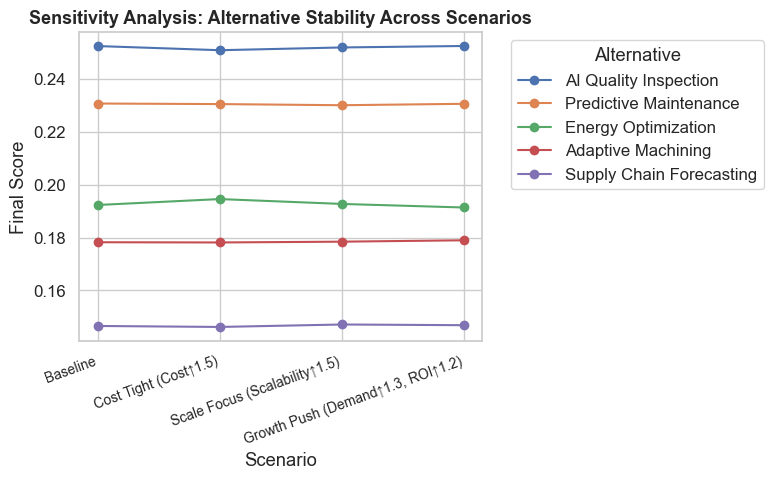

In [26]:
scenarios = {
    "Baseline": result_df["Final Score"].values,
    "Cost Tight (Cost↑1.5)": cost_tight["Score"].values,
    "Scale Focus (Scalability↑1.5)": scale_push["Score"].values,
    "Growth Push (Demand↑1.3, ROI↑1.2)": sales_push["Score"].values
}

alts = result_df["Alternative"].values
fig, ax = plt.subplots(figsize=(8,5))

for i, alt in enumerate(alts):
    y = [scenarios[s][i] for s in scenarios.keys()]
    ax.plot(list(scenarios.keys()), y, marker="o", label=alt)

ax.set_title("Sensitivity Analysis: Alternative Stability Across Scenarios", fontsize=13, weight="bold")
ax.set_ylabel("Final Score")
ax.set_xlabel("Scenario")

plt.xticks(rotation=20, ha="right", fontsize=10)

ax.legend(title="Alternative", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplots_adjust(bottom=0.25, right=0.8)

plt.tight_layout()
plt.show()


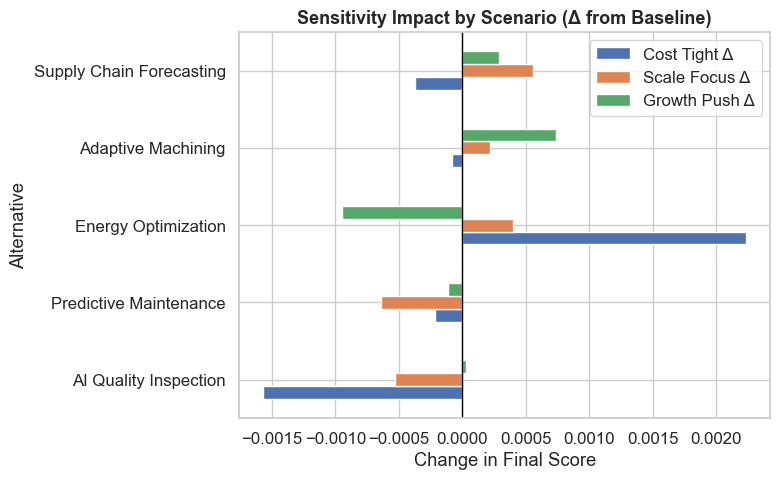

In [27]:
# Compute each alternative’s score change across the three scenarios (relative to the baseline)
baseline = result_df.set_index("Alternative")["Final Score"]
sensitivity_df = pd.DataFrame({
    "Alternative": alts,
    "Cost Tight Δ": cost_tight.set_index("Alternative")["Score"] - baseline,
    "Scale Focus Δ": scale_push.set_index("Alternative")["Score"] - baseline,
    "Growth Push Δ": sales_push.set_index("Alternative")["Score"] - baseline
}).set_index("Alternative")

sensitivity_df.plot(kind="barh", figsize=(8,5))
plt.title("Sensitivity Impact by Scenario (Δ from Baseline)", fontsize=13, weight="bold")
plt.xlabel("Change in Final Score")
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()


In [28]:
rng = np.random.default_rng(0)

def rerank_with_weights(w_top):  # w_top: array of length = #criteria
    # recompute final scores given top-level weights
    global_sub = {}
    for crit in criteria_names:
        sw,_ = sub_weights[crit]
        for sub_name, sub_w in zip(sub_map[crit], sw):
            global_sub[(crit, sub_name)] = w_top[criteria_names.index(crit)] * sub_w
    scores = np.zeros(len(alts))
    for (crit, sub_name), gsw in global_sub.items():
        scores += gsw * alt_local_weights[sub_name][0]
    scores /= scores.sum()
    return scores

def mc_dirichlet(n=5000, alpha=1.0):
    wins = {a:0 for a in alts}
    for _ in range(n):
        w = rng.dirichlet(np.ones(len(criteria_names))*alpha)
        scores = rerank_with_weights(w)
        wins[alts[np.argmax(scores)]] += 1
    return pd.Series(wins).sort_values(ascending=False)

def mc_wide_jitter(n=5000, jitter=0.4):
    wins = {a:0 for a in alts}
    for _ in range(n):
        w = w_criteria * (1 + rng.uniform(-jitter, jitter, size=len(w_criteria)))
        w = w / w.sum()
        scores = rerank_with_weights(w)
        wins[alts[np.argmax(scores)]] += 1
    return pd.Series(wins).sort_values(ascending=False)

mc_dirichlet_results = mc_dirichlet(5000, alpha=1.0)
mc_wide_results = mc_wide_jitter(5000, 0.40)
mc_dirichlet_results, mc_wide_results


(AI Quality Inspection       4592
 Energy Optimization          404
 Predictive Maintenance         4
 Adaptive Machining             0
 Supply Chain Forecasting       0
 dtype: int64,
 AI Quality Inspection       5000
 Predictive Maintenance         0
 Energy Optimization            0
 Adaptive Machining             0
 Supply Chain Forecasting       0
 dtype: int64)

In [29]:
alts = list(alts)

In [30]:
# compute boundary for scaling ONE criterion k by alpha (others unchanged then renormalized)
def flip_threshold(pair=("AI Quality Inspection","Predictive Maintenance"), crit_name="Implementation Cost"):
    targetA, targetB = pair
    k = criteria_names.index(crit_name)

    def score_with_alpha(alpha):
        w = w_criteria.copy()
        w[k] *= alpha
        w = w / w.sum()
        return rerank_with_weights(w)

    # bisection over alpha ∈ [0.05, 20] to find A==B
    lo, hi = 0.05, 20.0
    for _ in range(60):
        mid = (lo+hi)/2
        s = score_with_alpha(mid)
        diff = s[alts.index(targetA)] - s[alts.index(targetB)]
        (hi if diff>0 else lo).__init__  # no-op to prevent formatting collapse
        if diff>0: lo = mid
        else: hi = mid
    alpha_star = (lo+hi)/2
    s = score_with_alpha(alpha_star)
    gap_now = (rerank_with_weights(w_criteria)[alts.index(targetA)]
              - rerank_with_weights(w_criteria)[alts.index(targetB)])
    return alpha_star, gap_now

# examples:
flip_threshold(("AI Quality Inspection","Predictive Maintenance"), "Implementation Cost")
flip_threshold(("AI Quality Inspection","Predictive Maintenance"), "Scalability & Adoption")
flip_threshold(("AI Quality Inspection","Predictive Maintenance"), "Market Demand")


(20.0, 0.021703718619777823)

In [31]:
def shock_sub(crit, sub_name, factor=1.3):
    sw,_ = sub_weights[crit]
    names = sub_map[crit]
    sw2 = sw.copy()
    i = names.index(sub_name)
    sw2[i] *= factor
    sw2 = sw2 / sw2.sum()
    return dict(zip(names, sw2))

def rerank_with_subshock(crit, sub_name, factor=1.3):
    # rebuild global sub weights using shocked sub-weights for one criterion
    global_sub = {}
    for c in criteria_names:
        if c==crit:
            new_sw = shock_sub(crit, sub_name, factor)
            for sn, w in new_sw.items():
                global_sub[(c, sn)] = w_criteria[criteria_names.index(c)] * w
        else:
            sw,_ = sub_weights[c]
            for sn, w in zip(sub_map[c], sw):
                global_sub[(c, sn)] = w_criteria[criteria_names.index(c)] * w
    scores = np.zeros(len(alts))
    for (c,sn), gsw in global_sub.items():
        scores += gsw * alt_local_weights[sn][0]
    scores /= scores.sum()
    return pd.DataFrame({"Alternative": alts, "Score": scores}).sort_values("Score", ascending=False)

# e.g., assume at a specific client, PdM’s Data Availability is much better:
rerank_with_subshock("Technical Feasibility","Data Availability (DA)",factor=1.8)


,Alternative,Score
0,AI Quality Inspection,0.252155
1,Predictive Maintenance,0.230351
2,Energy Optimization,0.192758
3,Adaptive Machining,0.178349
4,Supply Chain Forecasting,0.146387


In [32]:
gap = crit_contrib.loc["AI Quality Inspection"].drop("Total") - crit_contrib.loc["Predictive Maintenance"].drop("Total")
gap.sort_values(ascending=False)


ROI Potential             0.009934
Technical Feasibility     0.005806
Market Demand             0.003989
Scalability & Adoption    0.003494
Implementation Cost      -0.001520
dtype: float64

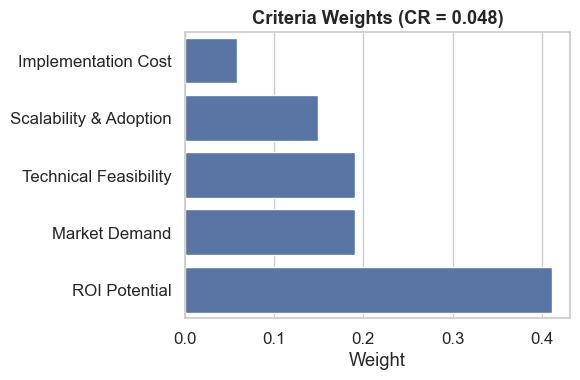

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("output", exist_ok=True)
sns.set_theme(style="whitegrid", font_scale=1.1)

# --- Criteria weights ---
plt.figure(figsize=(6,4))
sns.barplot(
    data=criteria_df.sort_values("Weight", ascending=True),
    x="Weight", y="Criterion", color="#4C72B0"
)
plt.title("Criteria Weights (CR = 0.048)", weight="bold")
plt.xlabel("Weight"); plt.ylabel("")
plt.tight_layout(); plt.savefig("output/criteria_weights.png", dpi=300)
plt.show()

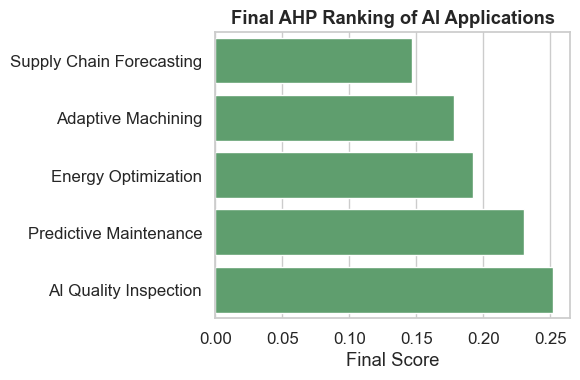

In [34]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=result_df.sort_values("Final Score", ascending=True),
    x="Final Score", y="Alternative", color="#55A868"
)
plt.title("Final AHP Ranking of AI Applications", weight="bold")
plt.xlabel("Final Score"); plt.ylabel("")
plt.tight_layout(); plt.savefig("output/final_ranking.png", dpi=300)
plt.show()


In [35]:
top2.T.plot(kind="bar", figsize=(6,4))
plt.title("Criterion Contributions: QI vs PdM", weight="bold")
plt.ylabel("Weighted Score Contribution")
plt.xlabel("Criterion")

plt.legend(title="Alternative", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("output/contribution_top2.png", dpi=300, bbox_inches="tight")
plt.show()


NameError: name 'top2' is not defined

In [ ]:
scenarios = {
    "Baseline": result_df["Final Score"].values,
    "Cost Tight": cost_tight["Score"].values,
    "Scale Focus": scale_push["Score"].values,
    "Growth Push": sales_push["Score"].values
}

alts = result_df["Alternative"].values
plt.figure(figsize=(7,5))
for i, alt in enumerate(alts):
    y = [scenarios[s][i] for s in scenarios]
    plt.plot(list(scenarios.keys()), y, marker="o", label=alt)

plt.title("Sensitivity Analysis: Stability Across Scenarios", weight="bold")
plt.ylabel("Final Score"); plt.xlabel("Scenario")
plt.legend(title="Alternative", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout(); plt.savefig("output/sensitivity_lines.png", dpi=300)
plt.show()

In [ ]:
target_crit = "ROI Potential"

scores = pd.DataFrame(index=np.round(np.linspace(0, 1, 50), 3), columns=alts, dtype=float)

for w in scores.index:
    new_weights = criteria_weights.copy()
    total_other = sum([v for k, v in criteria_weights.items() if k != target_crit])
    scale_factor = (1 - w) / total_other
    for k in new_weights:
        if k != target_crit:
            new_weights[k] *= scale_factor
    new_weights[target_crit] = w

    total_score = alt_scores.mul(new_weights).sum(axis=1)
    scores.loc[w] = total_score

plt.figure(figsize=(7,5))
for alt in alts:
    plt.plot(scores.index, scores[alt], linewidth=2, label=alt)
plt.title(f"Rank Reversal – {target_crit}", weight="bold")
plt.xlabel(f"Weight of {target_crit}")
plt.ylabel("Final Score")
plt.grid(alpha=0.4, linestyle="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"output/rank_reversal_{target_crit.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
target_crit = "Implementation Cost"
scores = pd.DataFrame(index=np.round(np.linspace(0, 1, 50), 3), columns=alts, dtype=float)

for w in scores.index:
    new_weights = criteria_weights.copy()
    total_other = sum([v for k, v in criteria_weights.items() if k != target_crit])
    scale_factor = (1 - w) / total_other
    for k in new_weights:
        if k != target_crit:
            new_weights[k] *= scale_factor
    new_weights[target_crit] = w
    total_score = alt_scores.mul(new_weights).sum(axis=1)
    scores.loc[w] = total_score

plt.figure(figsize=(7,5))
for alt in alts:
    plt.plot(scores.index, scores[alt], linewidth=2, label=alt)

for i in range(len(alts)):
    for j in range(i+1, len(alts)):
        diff = scores[alts[i]].to_numpy() - scores[alts[j]].to_numpy()
        cross_idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
        if len(cross_idx) > 0:
            x_cross = scores.index[cross_idx[0]]
            y_cross = scores[alts[i]].iloc[cross_idx[0]]
            plt.scatter(x_cross, y_cross, color="red", zorder=5)
            plt.text(x_cross, y_cross, f"({x_cross:.2f}, {y_cross:.3f})", fontsize=8, color="red")

plt.title(f"Rank Reversal – {target_crit}", weight="bold")
plt.xlabel(f"Weight of {target_crit}")
plt.ylabel("Final Score")
plt.grid(alpha=0.4, linestyle="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"output/rank_reversal_{target_crit.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
target_crit = "Market Demand"
scores = pd.DataFrame(index=np.round(np.linspace(0, 1, 50), 3), columns=alts, dtype=float)

for w in scores.index:
    new_weights = criteria_weights.copy()
    total_other = sum([v for k, v in criteria_weights.items() if k != target_crit])
    scale_factor = (1 - w) / total_other
    for k in new_weights:
        if k != target_crit:
            new_weights[k] *= scale_factor
    new_weights[target_crit] = w
    total_score = alt_scores.mul(new_weights).sum(axis=1)
    scores.loc[w] = total_score

plt.figure(figsize=(7,5))
for alt in alts:
    plt.plot(scores.index, scores[alt], linewidth=2, label=alt)

for i in range(len(alts)):
    for j in range(i+1, len(alts)):
        diff = scores[alts[i]].to_numpy() - scores[alts[j]].to_numpy()
        cross_idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
        if len(cross_idx) > 0:
            x_cross = scores.index[cross_idx[0]]
            y_cross = scores[alts[i]].iloc[cross_idx[0]]
            plt.scatter(x_cross, y_cross, color="red", zorder=5)
            plt.text(x_cross, y_cross, f"({x_cross:.2f}, {y_cross:.3f})", fontsize=8, color="red")

plt.title(f"Rank Reversal – {target_crit}", weight="bold")
plt.xlabel(f"Weight of {target_crit}")
plt.ylabel("Final Score")
plt.grid(alpha=0.4, linestyle="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"output/rank_reversal_{target_crit.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
target_crit = "Technical Feasibility"
scores = pd.DataFrame(index=np.round(np.linspace(0, 1, 50), 3), columns=alts, dtype=float)

for w in scores.index:
    new_weights = criteria_weights.copy()
    total_other = sum([v for k, v in criteria_weights.items() if k != target_crit])
    scale_factor = (1 - w) / total_other
    for k in new_weights:
        if k != target_crit:
            new_weights[k] *= scale_factor
    new_weights[target_crit] = w
    total_score = alt_scores.mul(new_weights).sum(axis=1)
    scores.loc[w] = total_score

plt.figure(figsize=(7,5))
for alt in alts:
    plt.plot(scores.index, scores[alt], linewidth=2, label=alt)

for i in range(len(alts)):
    for j in range(i+1, len(alts)):
        diff = scores[alts[i]].to_numpy() - scores[alts[j]].to_numpy()
        cross_idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
        if len(cross_idx) > 0:
            x_cross = scores.index[cross_idx[0]]
            y_cross = scores[alts[i]].iloc[cross_idx[0]]
            plt.scatter(x_cross, y_cross, color="red", zorder=5)
            plt.text(x_cross, y_cross, f"({x_cross:.2f}, {y_cross:.3f})", fontsize=8, color="red")

plt.title(f"Rank Reversal – {target_crit}", weight="bold")
plt.xlabel(f"Weight of {target_crit}")
plt.ylabel("Final Score")
plt.grid(alpha=0.4, linestyle="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"output/rank_reversal_{target_crit.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
target_crit = "Scalability & Adoption"
scores = pd.DataFrame(index=np.round(np.linspace(0, 1, 50), 3), columns=alts, dtype=float)

for w in scores.index:
    new_weights = criteria_weights.copy()
    total_other = sum([v for k, v in criteria_weights.items() if k != target_crit])
    scale_factor = (1 - w) / total_other
    for k in new_weights:
        if k != target_crit:
            new_weights[k] *= scale_factor
    new_weights[target_crit] = w
    total_score = alt_scores.mul(new_weights).sum(axis=1)
    scores.loc[w] = total_score

plt.figure(figsize=(7,5))
for alt in alts:
    plt.plot(scores.index, scores[alt], linewidth=2, label=alt)

for i in range(len(alts)):
    for j in range(i+1, len(alts)):
        diff = scores[alts[i]].to_numpy() - scores[alts[j]].to_numpy()
        cross_idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
        if len(cross_idx) > 0:
            x_cross = scores.index[cross_idx[0]]
            y_cross = scores[alts[i]].iloc[cross_idx[0]]
            plt.scatter(x_cross, y_cross, color="red", zorder=5)
            plt.text(x_cross, y_cross, f"({x_cross:.2f}, {y_cross:.3f})", fontsize=8, color="red")

plt.title(f"Rank Reversal – {target_crit}", weight="bold")
plt.xlabel(f"Weight of {target_crit}")
plt.ylabel("Final Score")
plt.grid(alpha=0.4, linestyle="--")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"output/rank_reversal_{target_crit.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# assume `mc_dirichlet_results` and `mc_wide_results` are pd.Series
mc_df = pd.DataFrame({
    "Dirichlet 5000": mc_dirichlet_results,
    "Wide ±40%": mc_wide_results
}).fillna(0).astype(int)

mc_df.plot(kind="bar", figsize=(6,4))
plt.title("Monte Carlo Win Rates (5 000 runs)", weight="bold")
plt.ylabel("Win Count"); plt.xlabel("Alternative")
plt.tight_layout(); plt.savefig("output/montecarlo_winrates.png", dpi=300)
plt.show()

In [ ]:
# build from earlier sensitivity_df if you created it
sensitivity_df.plot(kind="barh", figsize=(7,4))
plt.title("Scenario Impact (Δ from Baseline)", weight="bold")
plt.xlabel("Change in Final Score")
plt.axvline(0, color="black", lw=1)
plt.tight_layout(); plt.savefig("output/tornado_sensitivity.png", dpi=300)
plt.show()

In [ ]:
criteria_names = [
    "Market Demand",
    "ROI Potential",
    "Implementation Cost",
    "Technical Feasibility",
    "Scalability & Adoption"
]

A_criteria = np.array([
    [1,   1/3, 3,   1,   2],
    [3,   1,   5,   3,   2],
    [1/3, 1/5, 1,   1/3, 1/4],
    [1,   1/3, 3,   1,   2],
    [1/2, 1/2, 4,   1/2, 1]
], dtype=float)

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(A_criteria, annot=True, cmap="YlGnBu", xticklabels=criteria_names, yticklabels=criteria_names, fmt=".2f")
plt.title("Top-level Criteria Pairwise Matrix", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_criteria.png", dpi=300)
plt.show()


In [ ]:

# ===========================================================
# 1️⃣ Market Demand
# ===========================================================
subs_market = ["Pain Severity (P)", "Industry Growth (G)", "Competitive Pressure (X)"]
A_market = np.array([
    [1,   3,   7],
    [1/3, 1,   5],
    [1/7, 1/5, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_market, annot=True, cmap="YlGnBu", xticklabels=subs_market, yticklabels=subs_market, fmt=".2f")
plt.title("Sub-criteria Matrix: Market Demand", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_market_demand.png", dpi=300)
plt.show()

# ===========================================================
# 2️⃣ ROI Potential
# ===========================================================
subs_roi = ["Productivity Gain (PG)", "Defect/Downtime Reduction (DR)", "Time-to-ROI (TT)"]
A_roi = np.array([
    [1,   1,   5],
    [1,   1,   5],
    [1/5, 1/5, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_roi, annot=True, cmap="YlOrBr", xticklabels=subs_roi, yticklabels=subs_roi, fmt=".2f")
plt.title("Sub-criteria Matrix: ROI Potential", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_roi_potential.png", dpi=300)
plt.show()

# ===========================================================
# 3️⃣ Implementation Cost
# ===========================================================
subs_cost = ["Integration Complexity (IC)", "Initial Investment (I)", "HR/Training Demand (HR)"]
A_cost = np.array([
    [1,   3,   5],
    [1/3, 1,   3],
    [1/5, 1/3, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_cost, annot=True, cmap="RdPu", xticklabels=subs_cost, yticklabels=subs_cost, fmt=".2f")
plt.title("Sub-criteria Matrix: Implementation Cost", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_implementation_cost.png", dpi=300)
plt.show()

# ===========================================================
# 4️⃣ Technical Feasibility
# ===========================================================
subs_feas = ["Model Reliability (MR)", "Data Availability (DA)", "Infrastructure Readiness (IR)"]
A_feas = np.array([
    [1,   3,   5],
    [1/3, 1,   3],
    [1/5, 1/3, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_feas, annot=True, cmap="PuBu", xticklabels=subs_feas, yticklabels=subs_feas, fmt=".2f")
plt.title("Sub-criteria Matrix: Technical Feasibility", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_technical_feasibility.png", dpi=300)
plt.show()

# ===========================================================
# 5️⃣ Scalability & Adoption
# ===========================================================
subs_scale = ["Organizational Readiness (OR)", "Cross-Industry Replicability (CRS)", "Partnership/Ecosystem (PE)"]
A_scale = np.array([
    [1,   3,   5],
    [1/3, 1,   3],
    [1/5, 1/3, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_scale, annot=True, cmap="YlGnBu_r", xticklabels=subs_scale, yticklabels=subs_scale, fmt=".2f")
plt.title("Sub-criteria Matrix: Scalability & Adoption", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_scalability_adoption.png", dpi=300)
plt.show()


In [ ]:

# ===========================================================
# 1️⃣ Market Demand
# ===========================================================
subs_market = ["Pain Severity (P)", "Industry Growth (G)", "Competitive Pressure (X)"]
A_market = np.array([
    [1,   3,   7],
    [1/3, 1,   5],
    [1/7, 1/5, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_market, annot=True, cmap="YlGnBu", xticklabels=subs_market, yticklabels=subs_market, fmt=".2f")
plt.title("Sub-criteria Matrix: Market Demand", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_market_demand.png", dpi=300)
plt.show()

# ===========================================================
# 2️⃣ ROI Potential
# ===========================================================
subs_roi = ["Productivity Gain (PG)", "Defect/Downtime Reduction (DR)", "Time-to-ROI (TT)"]
A_roi = np.array([
    [1,   1,   5],
    [1,   1,   5],
    [1/5, 1/5, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_roi, annot=True, cmap="YlOrBr", xticklabels=subs_roi, yticklabels=subs_roi, fmt=".2f")
plt.title("Sub-criteria Matrix: ROI Potential", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_roi_potential.png", dpi=300)
plt.show()

# ===========================================================
# 3️⃣ Implementation Cost
# ===========================================================
subs_cost = ["Integration Complexity (IC)", "Initial Investment (I)", "HR/Training Demand (HR)"]
A_cost = np.array([
    [1,   3,   5],
    [1/3, 1,   3],
    [1/5, 1/3, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_cost, annot=True, cmap="RdPu", xticklabels=subs_cost, yticklabels=subs_cost, fmt=".2f")
plt.title("Sub-criteria Matrix: Implementation Cost", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_implementation_cost.png", dpi=300)
plt.show()

# ===========================================================
# 4️⃣ Technical Feasibility
# ===========================================================
subs_feas = ["Model Reliability (MR)", "Data Availability (DA)", "Infrastructure Readiness (IR)"]
A_feas = np.array([
    [1,   3,   5],
    [1/3, 1,   3],
    [1/5, 1/3, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_feas, annot=True, cmap="PuBu", xticklabels=subs_feas, yticklabels=subs_feas, fmt=".2f")
plt.title("Sub-criteria Matrix: Technical Feasibility", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_technical_feasibility.png", dpi=300)
plt.show()

# ===========================================================
# 5️⃣ Scalability & Adoption
# ===========================================================
subs_scale = ["Organizational Readiness (OR)", "Cross-Industry Replicability (CRS)", "Partnership/Ecosystem (PE)"]
A_scale = np.array([
    [1,   3,   5],
    [1/3, 1,   3],
    [1/5, 1/3, 1]
])

plt.figure(figsize=(5,4))
sns.heatmap(A_scale, annot=True, cmap="YlGnBu_r", xticklabels=subs_scale, yticklabels=subs_scale, fmt=".2f")
plt.title("Sub-criteria Matrix: Scalability & Adoption", weight="bold")
plt.tight_layout()
plt.savefig("output/matrix_scalability_adoption.png", dpi=300)
plt.show()


In [ ]:
criteria_weights = {
    "ROI Potential": 0.411,
    "Technical Feasibility": 0.190,
    "Market Demand": 0.190,
    "Scalability & Adoption": 0.150,
    "Implementation Cost": 0.059
}

plt.figure(figsize=(6,4))
sns.barplot(x=list(criteria_weights.keys()), y=list(criteria_weights.values()), palette="Blues_d")
plt.title("Criteria Weights Overview", weight="bold")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Weight")
plt.tight_layout()
plt.savefig("output/criteria_weights.png", dpi=300)
plt.show()


In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

RI_TABLE = {1:0.00, 2:0.00, 3:0.58, 4:0.90, 5:1.12, 6:1.24, 7:1.32, 8:1.41, 9:1.45, 10:1.49}

def ahp_weights(A: np.ndarray):
    eigvals, eigvecs = np.linalg.eig(A)
    idx = np.argmax(eigvals.real)
    lam_max = eigvals.real[idx]
    w = eigvecs[:, idx].real
    w = w / w.sum()
    n = A.shape[0]
    CI = (lam_max - n) / (n - 1) if n > 2 else 0.0
    RI = RI_TABLE.get(n, 1.49)
    CR = CI / RI if RI > 0 else 0.0
    return w, CR, lam_max

def ratio_to_pairwise(values, clip_min=1/9, clip_max=9.0):
    vals = np.array(values, dtype=float)
    n = len(vals); A = np.ones((n, n), float)
    for i in range(n):
        for j in range(n):
            r = vals[i]/vals[j] if vals[j]!=0 else clip_max
            A[i,j] = max(clip_min, min(clip_max, r))
    return A

def alt_weights_from_indicator(vec, invert=False):
    """Turn a 0–1 indicator vec into alternative weights (invert if 'lower is better')."""
    v = np.array(vec, float)
    if invert: v = 1.0 - v
    A = ratio_to_pairwise(v)
    w, _, _ = ahp_weights(A)
    return w


In [ ]:
# alternatives (order)
alts = [
    "AI Quality Inspection",
    "Predictive Maintenance",
    "Energy Optimization",
    "Adaptive Machining",
    "Supply Chain Forecasting"
]

# your indicators dict from earlier (0–1 scale per sub-criterion)
# indicators = { "Pain Severity (P)": [...5 vals...], ... }


In [ ]:
# Within-bucket weights (sum to 1 inside each bucket)
W_D = {"Pain Severity (P)":0.6, "Industry Growth (G)":0.3, "Competitive Pressure (X)":0.1}
W_R = {"Productivity Gain (PG)":0.429, "Defect/Downtime Reduction (DR)":0.429, "Time-to-ROI (TT)":0.143}
W_C = {"Integration Complexity (IC)":0.571, "Initial Investment (I)":0.286, "HR/Training Demand (HR)":0.143}
W_F = {"Model Reliability (MR)":0.571, "Data Availability (DA)":0.286, "Infrastructure Readiness (IR)":0.143}
W_S = {"Organizational Readiness (OR)":0.571, "Cross-Industry Replicability (CRS)":0.286, "Partnership/Ecosystem (PE)":0.143}

# BOCR bucket definitions (list of (subcriterion_name, invert_lower_is_better))
# B = Benefits (ROI + pieces of demand/scalability), O = Opportunities (future/scale),
# C = Costs (implementation cost), R = Risks (inverse of feasibility)
B_LIST = [
    ("Productivity Gain (PG)", False),
    ("Defect/Downtime Reduction (DR)", False),
    ("Time-to-ROI (TT)", True),              # shorter is better
    ("Pain Severity (P)", False),
    ("Industry Growth (G)", False),
    ("Competitive Pressure (X)", True)       # lower is better
]
O_LIST = [
    ("Organizational Readiness (OR)", False),
    ("Cross-Industry Replicability (CRS)", False),
    ("Partnership/Ecosystem (PE)", False),
    ("Industry Growth (G)", False)
]
C_LIST = [
    ("Integration Complexity (IC)", True),   # lower is better
    ("Initial Investment (I)", True),
    ("HR/Training Demand (HR)", True)
]
R_LIST = [
    ("Model Reliability (MR)", True),        # lower reliability ⇒ higher risk
    ("Data Availability (DA)", True),
    ("Infrastructure Readiness (IR)", True)
]

# Within-bucket weights for BOCR (normalized automatically below).
# We reuse original sub-weights where available; for items reused across buckets, split reasonably.
W_B = {"Productivity Gain (PG)":W_R["Productivity Gain (PG)"],
       "Defect/Downtime Reduction (DR)":W_R["Defect/Downtime Reduction (DR)"],
       "Time-to-ROI (TT)":W_R["Time-to-ROI (TT)"],
       "Pain Severity (P)":W_D["Pain Severity (P)"],
       "Industry Growth (G)":W_D["Industry Growth (G)"],
       "Competitive Pressure (X)":W_D["Competitive Pressure (X)"]}

W_O = {"Organizational Readiness (OR)":W_S["Organizational Readiness (OR)"],
       "Cross-Industry Replicability (CRS)":W_S["Cross-Industry Replicability (CRS)"],
       "Partnership/Ecosystem (PE)":W_S["Partnership/Ecosystem (PE)"],
       "Industry Growth (G)":0.15}  # small extra weight; will normalize

W_C = W_C  # using as-is
W_RISK = {"Model Reliability (MR)":W_F["Model Reliability (MR)"],
          "Data Availability (DA)":W_F["Data Availability (DA)"],
          "Infrastructure Readiness (IR)":W_F["Infrastructure Readiness (IR)"]}

# normalize each bucket’s weight dict to sum to 1
def _normalize(d):
    s = sum(d.values())
    return {k:v/s for k,v in d.items()}

W_B = _normalize(W_B)
W_O = _normalize(W_O)
W_C = _normalize(W_C)
W_RISK = _normalize(W_RISK)


In [ ]:
# Compute local alt weights for every sub-criterion used in BOCR
sub_alt_w = {}

def get_indicator(name):
    if name not in indicators:
        raise KeyError(f"Missing indicator: {name}")
    return indicators[name]

# Build weights
for name, inv in (B_LIST + O_LIST + C_LIST + R_LIST):
    if name in sub_alt_w: 
        continue
    vec = get_indicator(name)
    sub_alt_w[name] = alt_weights_from_indicator(vec, invert=inv)


In [ ]:
def bucket_score(weight_map, item_list):
    # weighted sum of alternative weights across the bucket
    M = np.zeros((len(alts),))
    for (name, _inv) in item_list:
        w_sub = sub_alt_w[name]              # alt weights for this subcriterion
        M += weight_map[name] * w_sub
    return M / M.sum()                       # normalize to 1 across alts (nice for plotting)

B_score = bucket_score(W_B, B_LIST)
O_score = bucket_score(W_O, O_LIST)
C_score = bucket_score(W_C, C_LIST)
R_score = bucket_score(W_RISK, R_LIST)

bocr_df = pd.DataFrame({
    "Alternative": alts,
    "B": B_score,
    "O": O_score,
    "C": C_score,
    "R": R_score
})
bocr_df


In [ ]:
eps = 1e-6
BOCR_mult = (bocr_df["B"] * bocr_df["O"]) / np.maximum(bocr_df["C"] * bocr_df["R"], eps)
BOCR_mult = BOCR_mult / BOCR_mult.sum()

# additive policy: emphasize upside while penalizing downside
wB, wO, wC, wR = 0.35, 0.25, 0.20, 0.20
BOCR_add = (wB*bocr_df["B"] + wO*bocr_df["O"] - wC*bocr_df["C"] - wR*bocr_df["R"])
# shift + normalize to positive for plotting
BOCR_add = (BOCR_add - BOCR_add.min()) + eps
BOCR_add = BOCR_add / BOCR_add.sum()

rank_df = pd.DataFrame({
    "Alternative": alts,
    "BOCR_mult": BOCR_mult.values,
    "BOCR_add": BOCR_add.values
}).sort_values("BOCR_mult", ascending=False)
rank_df


In [ ]:
BO = (bocr_df["B"] + bocr_df["O"]).values
CR = (bocr_df["C"] + bocr_df["R"]).values

plt.figure(figsize=(6,5))
plt.scatter(CR, BO)
for i, name in enumerate(bocr_df["Alternative"]):
    plt.annotate(name, (CR[i], BO[i]), xytext=(5,5), textcoords="offset points")
plt.xlabel("Costs + Risks (lower is better)")
plt.ylabel("Benefits + Opportunities (higher is better)")
plt.title("BOCR Policy Lens (2×2)")
plt.grid(True)
plt.show()
